In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_plot_labels,
    clean_ticks,
    savefig,
    plot_pval
)
from sklearn.utils import resample
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit, OptimizeWarning

from joblib import Parallel, delayed
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
figure_cfg = analysis_config["figures"]

In [5]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(raw_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [7]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"
if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

rle_save_file = features_save_file.replace("snippet", "usage")
dirname, filename = os.path.split(features_save_file)
file, ext = os.path.splitext(filename)
file = os.path.join(proc_dirs["dlight"], file)
if lagged_cfg["estimate_within_bin"]:
    file = f"{file}_withinbin"

# file = f"{file}_{use_tup}"
corr_file = f"{file}_lag_global_entropy_correlations.parquet"
shuffle_file = f"{file}_lag_global_entropy_shuffle.parquet"
ents_file = f"{file}_lag_global_entropy_ents.parquet"

In [8]:
# use_tup = str(tuple(lagged_cfg["use_window"]))

In [9]:
use_features = []
for _use_win in lagged_cfg["use_windows"]:
    use_features += [f"{_}_{_use_win}" for _ in lagged_cfg["use_neural_features"]]
scalar_keys = lagged_cfg["usage_and_scalars"]["scalars"]

## Plot it!

In [11]:
beh_features = ["entropy"]

In [12]:
correlation_keys = lagged_cfg["entropy"]["correlation_keys"]
if lagged_cfg["estimate_within_bin"]:
    correlation_keys = ["time_bin"] + correlation_keys

In [13]:
corr_cols = ["dlight_bin", "entropy"]
agg_keys = ["bin", "feature", "time_bin", "dlight_bin_feature"]
final_agg_keys = ["dlight_bin_feature", "bin"]

In [14]:
obs_corrs = pd.read_parquet(corr_file)
shuffle_df = pd.read_parquet(shuffle_file).xs("dlight_bin", level="feature")
ents = pd.read_parquet(ents_file)["tm"]

In [15]:
obs_corrs = obs_corrs.groupby(agg_keys).mean().xs("dlight_bin", level="feature")

shuffle_mus = shuffle_df.groupby(obs_corrs.index.names).mean()
shuffle_sigs = shuffle_df.groupby(obs_corrs.index.names).std()
obs_mu = ((obs_corrs - shuffle_mus) / shuffle_sigs).groupby(final_agg_keys).mean()

In [16]:
shuffle_mu = (
    shuffle_df.reset_index().set_index(shuffle_mus.index.names + ["idx"])[corr_cols]
    - shuffle_mus[corr_cols]
) / shuffle_sigs[corr_cols]

In [17]:
chance = shuffle_mu.abs().groupby(["bin"]).quantile(0.95).max(axis=1)

In [18]:
shuffle_compare = (
    shuffle_mu.groupby(final_agg_keys + ["idx"]).mean().loc[use_features, beh_features]
)
shuffle_compare.index = shuffle_compare.index.droplevel("idx")
obs_compare = obs_mu.loc[use_features, beh_features]

dfs = []
for _feature in beh_features:
    _pval = obs_compare.groupby(["dlight_bin_feature", "bin"])[_feature].apply(
        lambda x: (
            x.abs().values < shuffle_compare.loc[x.name][_feature].abs().values
        ).mean()
    )
    dfs.append(_pval)
pval_df = pd.concat(dfs, axis=1)

from statsmodels.stats.multitest import multipletests
pval_df.values[:] = multipletests(pval_df.values.ravel(), method="holm")[1].reshape(
    -1, 1
)

In [19]:
setup_plotting_env()

In [20]:
threshold = 0

In [21]:
correlation_keys = ["time_bin", "bin"]

In [22]:
neural_feature = "signal_reref_dff_z_max_(0.0, 0.3)"
idx=0
use_kwargs={"window": 1, "min_periods": 1}

In [23]:
def fitter(
    idx,
    neural_feature="signal_reref_dff_z_max_abs_peak",
    beh_feature="count",
    threshold=threshold,
    smooth_kwargs={},
    pin_zero=True,
):

    default_kwargs = {"window": 1, "min_periods": 1, "center": True}
    use_kwargs = {**default_kwargs, **smooth_kwargs}

    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    use_ent = ents.xs(neural_feature, level="dlight_bin_feature").rename("entropy")
    use_shuffle_mu = shuffle_mus.xs(neural_feature, level="dlight_bin_feature")
    use_shuffle_sig = shuffle_sigs.xs(neural_feature, level="dlight_bin_feature")

    res_mu = resample(use_ent.reset_index(), random_state=idx).reset_index()
    res_mu["dlight_bin"] = res_mu["dlight_bin"].astype("float")
    res_mu = res_mu.groupby(correlation_keys)[corr_cols].corr(
        **lagged_cfg["entropy"]["corr_kwargs"]
    )

    res_mu.index = res_mu.index.set_names("feature", level=-1)
    res_mu = res_mu["entropy"].rolling(**use_kwargs).mean().xs("dlight_bin", level="feature")
    res_mu = (res_mu - use_shuffle_mu["entropy"]) / use_shuffle_sig["entropy"]
    res_mu = res_mu.groupby("bin").mean()

    # localize to the peak val
    x = res_mu.index
    y = res_mu.values

    maxloc = np.argmax(np.abs(y))
    if y[maxloc] < 0:
        y *= -1

    x = x[maxloc:]
    y = y[maxloc:]

    if len(x) < 3:
        return {}

    if pin_zero:
        y -= threshold
        y = np.clip(y, 0, np.inf)
        use_threshold = 0
    else:
        use_threshold = threshold

    # set everything less than threshold to 0? this would get rid of weirdness with slope..
    try:
        import warnings

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", OptimizeWarning)
            popt, pcov = curve_fit(func, x, y, p0=[y[0], 0.05, 0])
        fitted_vals = func(x, *popt)
        dct = {
            "a": popt[0],
            "b": popt[1],
            "offset": popt[2],
            "tau": 1 / popt[1],
            "index": idx,
            "beh_feature": beh_feature,
            "neural_feature": neural_feature,
            "r2": r2_score(y, fitted_vals),
        }
    except RuntimeError:
        dct = {}

    return dct

In [24]:
chk_features = use_features

In [25]:
beh_features = [
    "entropy",
]

In [26]:
chk_features

['signal_reref_dff_z_max_(0.0, 0.3)']

In [27]:
chk_features = (
    obs_corrs.index.get_level_values("dlight_bin_feature")
    .intersection(chk_features)
    .unique()
    .tolist()
)

In [28]:
dfs = []
delays = []

for _neural_feature in chk_features:
    for _feature in beh_features:
        _fitter = partial(
            fitter, beh_feature=_feature, neural_feature=_neural_feature, pin_zero=True
        )
        for _resample in range(lagged_cfg["nshuffles"]):
            delays.append(delayed(_fitter)(_resample))
ret_list = Parallel(n_jobs=-10, verbose=5)(delays)

[Parallel(n_jobs=-10)]: Using backend LokyBackend with 119 concurrent workers.
[Parallel(n_jobs=-10)]: Done  50 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-10)]: Done 212 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-10)]: Done 410 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-10)]: Done 644 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-10)]: Done 964 out of 1000 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=-10)]: Done 1000 out of 1000 | elapsed:    4.8s finished


In [29]:
decay_df = pd.DataFrame([_ for _ in ret_list if _ is not None])

In [30]:
setup_plotting_env()

In [31]:
neural_feature = chk_features[0]

In [32]:
aliases = {
    "count": "counts",
    "pseudocount": "counts",
    "usage": "usages",
    "velocity_2d_mm_bin": "vel.",
    "velocity_height_bin": "z vel.",
    "velocity_angle_bin": "ang. vel.",
    "acceleration_2d_mm_bin": "acc.",
    f"{neural_feature}_global_bin": "dLight peak (global)",
    f"{neural_feature}_specific_bin": "dLight peak (specific)",
    "entropy": "entropy",
}

In [33]:
use_decay_df = decay_df[
    (decay_df["r2"] > 0.05)
    & (decay_df["tau"].between(0, 1000))
    & (decay_df["a"] > threshold)
]

In [34]:
show_decay = [
    "entropy",
]

In [35]:
chance_col = "entropy"

In [36]:
use_offline = lagged_cfg["use_offline"]
renormalize = lagged_cfg["use_renormalized"]
within_bin = lagged_cfg["estimate_within_bin"]

In [37]:
neural_feature = chk_features[0]

smooth_kwargs = {"window": 1, "min_periods": 1, "center": True}

alpha_thresh = 0.05
continuity_thresh = 0

palette = sns.color_palette()

syllable_stats = toml.load(
    os.path.join(proc_dirs["dlight"], "syllable_stats_photometry_offline.toml")
)
duration = np.around(float(syllable_stats["duration"]["median"]), 1)

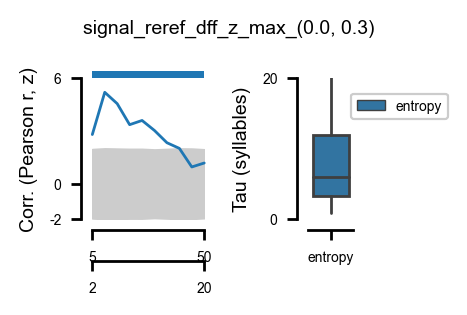

In [38]:
for neural_feature in chk_features:
    fig, ax = plt.subplots(
        1,
        2,
        figsize=(2.3, 1.7),
        sharex=False,
        sharey=False,
        gridspec_kw={"width_ratios": [2.5, 1]},
    )
    for _beh in beh_features:
        ax[0].plot(
            obs_mu.xs(neural_feature, level="dlight_bin_feature")[_beh]
            .rolling(**smooth_kwargs)
            .mean(),
            label=aliases[_beh],
            clip_on=False,
            alpha=1 if _beh in show_decay else 0.25,
        )

        ax[0].set_ylim(-2, 6)
    ax[0].set_xlim(5, 50)

    ax[0].fill_between(
        chance.index,
        -chance,
        +chance,
        zorder=-200,
        color=[0.8, 0.8, 0.8],
    )

    keys = beh_features
    key_level = "feature"
    plot_pval(
        pval_df.loc[neural_feature],
        keys,
        key_level,
        ax=ax[0],
        colors=palette,
        offset=1.0,
        height=0.05,
        spacing=1.3,
        min_width=0,
        alpha_threshold=alpha_thresh,
        continuity_threshold=continuity_thresh,
    )

    sns.boxplot(
        data=use_decay_df.loc[use_decay_df["neural_feature"] == neural_feature],
        x="beh_feature",
        order=show_decay,
        hue="beh_feature",
        hue_order=beh_features,
        dodge=False,
        showfliers=False,
        showcaps=False,
        #     legend=False,
        y="tau",
        ax=ax[1],
    )

    plt.legend().remove()
    ax[0].set_ylabel("Corr. (Pearson r, z)")
    ax[1].set_ylabel("Tau (syllables)")
    ax[1].set_xlabel("")
    ax[1].set_ylim(0, 20)

    l = ax[1].legend(bbox_to_anchor=(0.8, 0.8), framealpha=1, loc="center left")
    [_.set_text(aliases[_.get_text()]) for _ in l.get_texts()]
    # ax[0].set_xlabel("Syllables from dLight analysis window")
    clean_plot_labels(label_map=aliases)
    clean_ticks(ax[1], "y", precision=0, dtype=int)
    clean_ticks(ax[0], "y", precision=0, zero_symmetry=False, dtype=int)

    plt.setp(ax[1].get_xticklabels(), rotation=90, ha="center")
    syllables_to_time = lambda x: x * duration
    time_to_syllables = lambda x: x / duration

    ax[0].set_xticks([5, 50])
    secax_x = ax[0].secondary_xaxis(
        -0.3, functions=(syllables_to_time, time_to_syllables)
    )
    secax_x.set_ticks([2, 20])

    sns.despine(offset=4)
    fig.suptitle(neural_feature, fontsize=7)
    fig.tight_layout()
    savefig(
            fig, os.path.join(figure_cfg["store_dir"], f"correlation_decay_analysis_global_entropy_{neural_feature}"), bbox_inches="tight"
    )

In [39]:
import json

In [40]:
with open(os.path.join(proc_dirs["dlight"], "stats_lagged_entropy.toml"), "w") as f:
    plt_json = json.loads(pval_df.loc["signal_reref_dff_z_max_(0.0, 0.3)"].to_json())
    plt_json["stat_type"] = "Pearson correlation"
    plt_json["p_type"] = "Comparison to shuffle"
    toml.dump(plt_json, f)